<h1>Case Study: Online Retail</h1>

<h2>A. Project Overview</h2>

**Purpose:**

This customer segmentation is designed as a preparatory step toward building a more robust and differentiated customer management framework.

An analysis of historical transaction data from 2011 reveals several distinct and recurring purchasing behavior patterns, suggesting that engaging all customers as a homogeneous group does not align with the company’s actual sales dynamics.

Based on these observations, this project segments historical customers using unsupervised learning to provide a reusable and extensible analytical framework that can support downstream strategic decision-making. It is important to note that this model is descriptive in nature and does not aim to predict future customer behavior.

**Sources & Tools:**
* Data Source: UCI Online Retail Dataset. Link: https://archive.ics.uci.edu/dataset/352/online+retail
* Data Cleaning: SQL
* Analysis & Feature Engineering: Python
* Rationale: SQL used for structural and rule-based cleaning; Python used for exploratory and analytical tasks

<h2>B. Summary of Data Preparation</h2>
<h3>1. Quality Check</h3>

<h4>1-1. Data Completeness</h4>

* Number of rows - 541909
* Number of unique rows with duplication - 4880 (each unique row only remains one)
* No missing values
* Anonymous transactions - 135080 (potential impact on customer-level analysis)

<h4>1-2. Data Type</h4>

* All *InvoiceDate* can be parsed as timestamp
    * *InvoiceDate* might be converted into the type of 'DATETIME' as a new field.
* No abnormal date and time (range from '2010-12-01' to '2011-12-9')
* Types of numeric fields (*Quantity*, *UnitPrice*) have been set up as 'Integer' and 'Float' when importing dataset. 

<h4>1-3. Range of Numeric Fields</h4>

* Number of rows with non-positive quantity - 10624
  * No zero value
  * Negative quantities usually represents returns
* Number of rows with non-positive unit price - 2521
  * 2519 zero values, 2 negative values
  * abnormal price might represent promotion, free gifts or error
* Unable to check outliers through the quartile method (discrete *Quantity* and *UnitPrice*)

<h4>1-4. Business Semantics</h4>

* Number of rows as cancelled transactions - 9288
* Number of rows as cancelled transactions with negative quantities - 9288
* Number of invoices - 25900 (each invoice / order includes several products)

<h4>1-5. Text Quality</h4>

* Number of empty - 1454
* Whether each product has only one way to describe it - No (1321 products with several different descriptions)

<h4>1-6. Regional Field</h4>

* 37 countries and 'unspecified' situation, no abnormal values
* Number of rows with unspecified countries - 446 (0.00082% of total rows)
* Customers in the United Kingdom have the most transactions

<h3>2. Data Clean</h3>

<h4>2-1. Overall Removing Duplicates</h4>

Each unique rows only remains one. After removing duplicates, there are 536641 rows which matches with the previous expectation.

<h4>2-2. Transaction Attribute Processing</h4>

* Negative quantities - Preffix of *InvoiceNo* is 'C': cancelled transactions; else: unknown situations
  * Add a new column for labelling - *quan_cancel_flag*: normal / cancelled / other
* Negative unit price
  * Add a new column for labelling - *uniprice_flag*: normal / negative / zero
* To further handling special situations - Considerring such as combination of several relevant fields or ratio

<h4>2-3. Customer Identification</h4>

A new column *customer_flag* is added for labelling known customer ID (identified) and unknown customer ID (anonymous).

<h4>2-4. Uniforming Date</h4>

Through SQL to convert data type of *InvoiceDate* from *VARCHAR* to *DATETIME*.

<h2>C. Load Clean Data</h2>

* Data from table **online_retail_clean**
* Accessed by Python

In [1]:
import pandas as pd
import os, math
import matplotlib.pyplot as plt
import numpy as np
from sqlalchemy import create_engine
from dotenv import load_dotenv

In [2]:
# load the configuration file
load_dotenv('or.env')
# DB_USER=your_username
# DB_PASSWORD=your_password
# DB_HOST=localhost
# DB_PORT=3306
# DB_NAME=your_database

True

In [3]:
engine = create_engine(
    f"mysql+pymysql://{os.getenv('DB_USER')}:"
    f"{os.getenv('DB_PASSWORD')}@"
    f"{os.getenv('DB_HOST')}:"
    f"{os.getenv('DB_PORT')}/"
    f"{os.getenv('DB_NAME')}"
)

In [4]:
# load data from sql
df = pd.read_sql(
    "SELECT * FROM online_retail_clean", engine
)

In [5]:
# close DB connection pool
engine.dispose()

<h2>D. Sanity Check</h2>

To check whether cleaning work in SQL is valid as expected.

<h3>1. Basic Structure</h3>

In [6]:
# basic structure check
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536641 entries, 0 to 536640
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   InvoiceNo         536641 non-null  object        
 1   StockCode         536641 non-null  object        
 2   Description       536641 non-null  object        
 3   invoice_date      536641 non-null  datetime64[ns]
 4   Quantity          536641 non-null  int64         
 5   quan_cancel_flag  536641 non-null  object        
 6   UnitPrice         536641 non-null  float64       
 7   uniprice_flag     536641 non-null  object        
 8   CustomerID        536641 non-null  int64         
 9   Country           536641 non-null  object        
 10  customer_flag     536641 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(7)
memory usage: 45.0+ MB


**Conclusion:**
* Row & column number - Reasonable
* Column name - Consistent with SQL design
* No columns with fully or partially missing
* Data type of numeric values and dates - Reasonable

<h3>2. Numeric Fields</h3>

In [7]:
# numeric fields: quantity
## maximum & minimum
max_quan = max(df['Quantity'])
min_quan = min(df['Quantity'])
print(f'maximum and minimum quantity: {max_quan}, {min_quan}')

maximum and minimum quantity: 80995, -80995


In [8]:
## negative counts & zero counts
neg_quan = (df['Quantity'] < 0).sum()
zero_quan = (df['Quantity'] == 0).sum()
print(f'count of negative: {neg_quan}')
print(f'count of zero: {zero_quan}')

count of negative: 10587
count of zero: 0


In [9]:
# numeric fields: unit price
## negative counts & zero counts
neg_price = (df['UnitPrice'] < 0).sum()
zero_price = (df['UnitPrice'] == 0).sum()
print(f'count of negative: {neg_price}')
print(f'count of zero: {zero_price}')
## maximum
max_price = max(df['UnitPrice'])
print(f'maximum unit price: {max_price}')

count of negative: 2
count of zero: 2514
maximum unit price: 38970.0


**Conclusion:**
* Numberic fields - Reasonable
* Extreme values - Existing, but being not handled at this stage

<h3>3. Business Labels</h3>


In [10]:
# business labels: transaction status
## view the row count
cnt_tran = df['quan_cancel_flag'].value_counts()
## view the percentage of each label
pct_tran = df['quan_cancel_flag'].value_counts(normalize = True) * 100
## combine into a dataframe
res_tran = pd.DataFrame({'Count': cnt_tran, 'Percent %': round(pct_tran, 2)})
res_tran

,Count,Percent %
quan_cancel_flag,,
normal,526054,98.03
cancelled,9251,1.72
other,1336,0.25


In [11]:
## cancelled transactions with negative quantity
can_neg_tran = (
    (df['quan_cancel_flag'] == 'cancelled') & (df['Quantity'] < 0)
).sum()
## normal transactions with negative quantity
nor_neg_tran = (
    (df['quan_cancel_flag'] == 'normal') & (df['Quantity'] < 0)
).sum()
print(f'count of cancelled transactions with negative quantity: {can_neg_tran}')
print(f'count of normal transactions with negative quantity: {nor_neg_tran}')

count of cancelled transactions with negative quantity: 9251
count of normal transactions with negative quantity: 0


**Conclusion:**
* 98% of transactions - Normal
* 1.7% of transactions - Cancelled
* 0.3% of transactions - Other adjustment
* All **normal** transactions are purchasing products
* All **cancelled** transactions are returning products

In [12]:
# business labels: unit price status
## view the row count
cnt_price = df['uniprice_flag'].value_counts()
## view the percentage of each label
pct_price = df['uniprice_flag'].value_counts(normalize = True) * 100
## combine into a dataframe
res_price = pd.DataFrame({
    'Count': cnt_price, 'Percent %': round(pct_price, 4)
})
res_price

,Count,Percent %
uniprice_flag,,
normal,534125,99.5312
zero,2514,0.4685
negative,2,0.0004


In [101]:
## transactions pattern with zero price 
zero_price_df = df[df['uniprice_flag'] == 'zero'] 
zero_by_stock = (
    zero_price_df
        .groupby('StockCode')
        .size()
        .sort_values(ascending = False)
)
zero_by_stock

StockCode
23084           16
35965           13
20713           11
22501           10
22084            9
                ..
22577            1
22578            1
22580            1
22585            1
gift_0001_30     1
Length: 1420, dtype: int64

In [102]:
# how many products with once or twice zero-price transactions
(zero_by_stock == 1).sum() + (zero_by_stock == 2).sum()

1162

In [14]:
# calculate ratio of zero-price transactions in all transactions
round(
    len(zero_price_df.groupby('StockCode').nunique()) 
    / len(df.groupby('StockCode').nunique())
, 4)

0.3489

**Conclusion:**
* 99% of transactions have **normal** pricing
* Extremely few transactions have **zero** pricing
* 34.9% of all products have zero-price transactions

Many products (1420 distinct StockCode) have been involved in the zero-price transactions. Among them, the majority (approximately 1200 products) has an extremely less (1 to 2 records) frequency of this situation. The amount of the zero-price transactions does not achieve 0.5% of all transactions. This patterns indicate that current situation is a slight buniness adjustment, rather than systematic pricing issues.

<h3>4. Customer Identification</h3>

The status of customer identification is checked at the transaction level. Due to the fact that each invoice might contain several distinct products purchased by a single customer. Thus, the amount reflects how many rows marked as 'identified' or 'anonymous', rather than how many distinct customers or invoices.

In [15]:
# customer labels
## view the row count
cnt_cus = df['customer_flag'].value_counts()
## view the percentage of each label
pct_cus = df['customer_flag'].value_counts(normalize = True) * 100
## combine into a dataframe
res_cus = pd.DataFrame({
    'Count': cnt_cus, 'Percent %': round(pct_cus, 2)
})
res_cus

,Count,Percent %
customer_flag,,
identified,401604,74.84
anonymous,135037,25.16


**Conclusion:**

As shown in the table, the distribution is consistent with the expectation and proves taht *customer_flag* runs as SQL design.

In [16]:
## anonymous: GMV / Overall Sales
### calculate sales each row
df['sales'] = df['Quantity'] * df['UnitPrice'] 
gmv_by_flag = (
    df
    .groupby('customer_flag')['sales']
    .sum()
)
gmv_pct = gmv_by_flag / gmv_by_flag.sum() * 100 
### combine into a dataframe
gmv_res = pd.DataFrame({
    'GMV': gmv_by_flag,
    'Percent %': round(gmv_pct, 2)
})
gmv_res

,GMV,Percent %
customer_flag,,
anonymous,1447487.53,14.88
identified,8278519.42,85.12


**Conclusion:**
* Anonymous customers - < 20% of total sales, no need to be as the main part for customer-level analysis
* Identified customers - > 80% of total sales, a reliable basis at customer level 

<h3>5. Duplication Validation</h3>

In [100]:
# mark duplicated row
df.duplicated().value_counts()

False    536641
Name: count, dtype: int64

**Conclusion:**

No duplicated rows.

<h2>E. EDA</h2>

<h3>1. Overall Transaction Overview</h3>

In [18]:
# total rows
row_cnt = len(df)
# total invoice counts
order_cnt = df['InvoiceNo'].nunique()
# average count of items each order
item_avg = round(
    df
    .groupby('InvoiceNo')
    .size()
    .mean()
    , 2
)

In [19]:
# total GMV
gmv_total = round(df['sales'].sum(), 2)
# GMV: normal vs cancelled vs other transactions
gmv_by_status = (
    df
    .groupby('quan_cancel_flag')['sales']
    .sum()
)
gross_gmv = gmv_by_status.loc['normal']
cancel_gmv = gmv_by_status.loc['cancelled']
other_gmv = gmv_by_status.loc['other']
cancel_ratio = round(abs(cancel_gmv) / gross_gmv, 4)
# combine into a dataframe
overall_res = pd.DataFrame({
    'Total row count': row_cnt,
    'Total order count': order_cnt,
    'Avg item count per order': item_avg,
    'Total GMV': gmv_total,
    'GMV (normal)': gross_gmv,
    'GMV (cancel)': cancel_gmv,
    'Cancel ratio': cancel_ratio
}, index = ['Overall'])
overall_res

,Total row count,Total order count,Avg item count per order,Total GMV,GMV (normal),GMV (cancel),Cancel ratio
Overall,536641,25900,20.72,9726006.95,10619986.68,-893979.73,0.0842


**Conclusion:**
* Total row count and total order count match with SQL results.
* For average number of products per order: From the transaction perspective, the average number of products per invoice is approximately 20.7, reflecting the batch order characteristics of this dataset.

<h3>2. Time-based Analysis</h3>

In [20]:
# extract year & month from invoice date
df['year_month'] = df['invoice_date'].dt.to_period('M')

In [21]:
# monthly oreder count trend
monthly_orders = (
    df
    .groupby('year_month')['InvoiceNo']
    .nunique()
)
monthly_orders = monthly_orders.sort_index() # over time

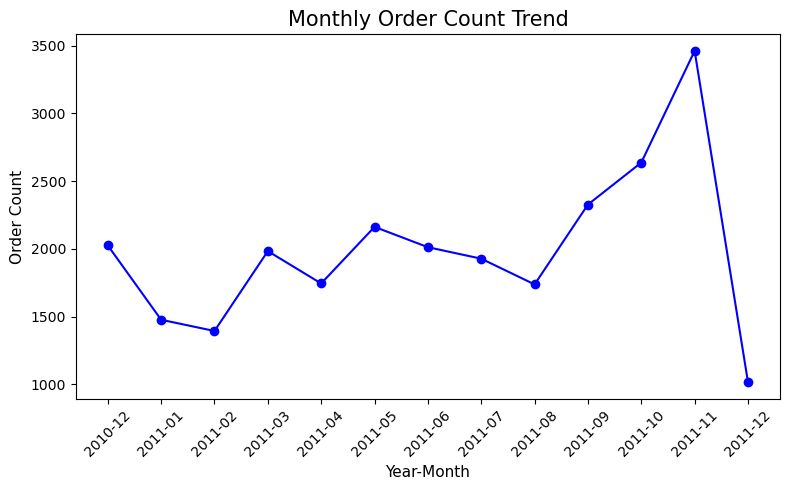

In [22]:
## draw firgure
x1 = monthly_orders.index.astype(str)
y1 = monthly_orders.values
plt.figure(figsize = (8, 5))
plt.plot(
    x1, 
    y1, 
    marker = 'o', 
    linestyle = '-', 
    color = 'b'
)
plt.title('Monthly Order Count Trend', fontsize = 15)
plt.xlabel('Year-Month', fontsize = 11)
plt.ylabel('Order Count', fontsize = 11)
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

In [23]:
# monthly GMV trend
monthly_gmv = (
    df
    .groupby('year_month')['sales']
    .sum()
)

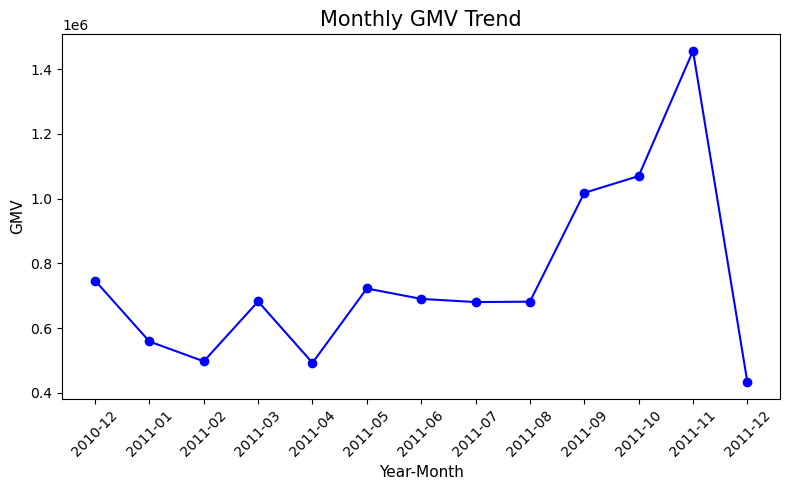

In [24]:
## draw firgure
x2 = monthly_gmv.index.astype(str)
y2 = monthly_gmv.values
plt.figure(figsize = (8, 5))
plt.plot(
    x2,
    y2,
    marker = 'o',
    linestyle = '-',
    color = 'b'
)
plt.title('Monthly GMV Trend', fontsize = 15)
plt.xlabel('Year-Month', fontsize = 11)
plt.ylabel('GMV', fontsize = 11)
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

In [25]:
# monthly average items per order
monthly_items = (
    df
    .groupby(['year_month', 'InvoiceNo'])
    .size()
    .groupby('year_month')
    .mean()
)

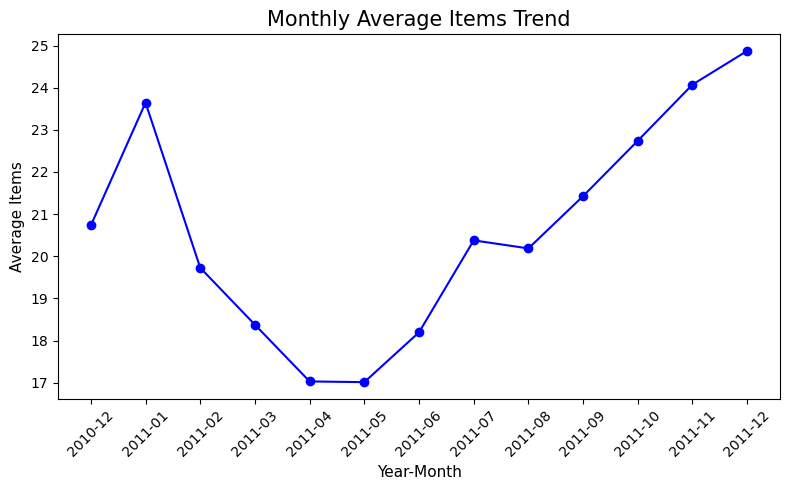

In [26]:
## draw firgure
x3 = monthly_items.index.astype(str)
y3 = monthly_items.values
plt.figure(figsize = (8, 5))
plt.plot(
    x3,
    y3,
    marker = 'o',
    linestyle = '-',
    color = 'b'
)
plt.title('Monthly Average Items Trend', fontsize = 15)
plt.xlabel('Year-Month', fontsize = 11)
plt.ylabel('Average Items', fontsize = 11)
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

**Conclusion**:

As shown in there figures, during 2011, monthly number of orders and total sales of transactions both demonstrate continuous increasing trend, while average quantity of product keeps stable over time. This indicates that the increased GMV is driven mainly by transaction frequency, rather than the fluctuation of structure of orders. 

The seasonal peak is in November 2011, which is in line with the expectation of the year-end retail pattern. The dramatic decline in December 2011 is caused by incomplete data coverage, and thus it will be not involved in the trend analysis.

<h3>3. Product-level Analysis</h3>

In [27]:
# sales distribution by different products
sales_by_product = (
    df
    .groupby('StockCode')['sales']
    .sum()
)

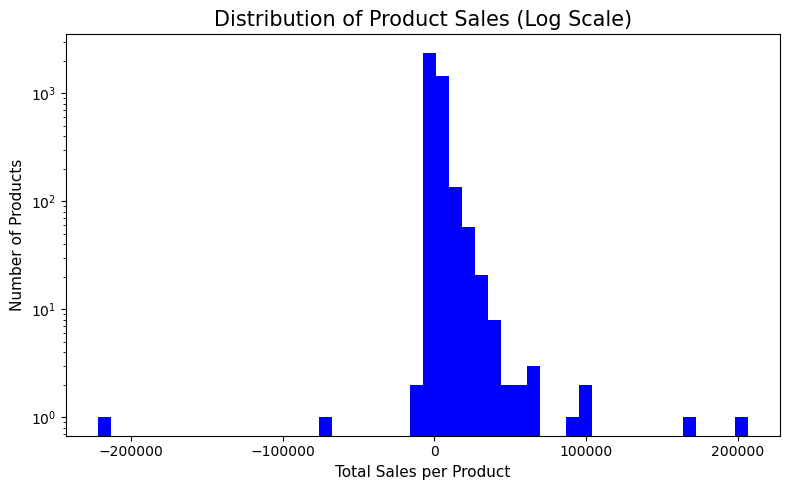

In [28]:
## draw figure
plt.figure(figsize = (8, 5))
plt.hist(
    sales_by_product,
    bins = 50,
    log = True,
    color = 'b'
)
plt.title('Distribution of Product Sales (Log Scale)', fontsize = 15)
plt.xlabel('Total Sales per Product', fontsize = 11)
plt.ylabel('Number of Products', fontsize = 11)
plt.tight_layout()
plt.show()

**Conclusion:**

As shown in the figure, a long tail can be observed significantly, which means that few products contribute a large number of sales. A few bars on the left (negative value) belong to cancelled transactions. The further step is to validate through cumulative GMV ratio and top-selling products.

In [29]:
# cumulative GMV ratio
sales_sorted = sales_by_product.sort_values(ascending = False)
cum_gmv_ratio = sales_sorted.cumsum() / sales_sorted.sum()

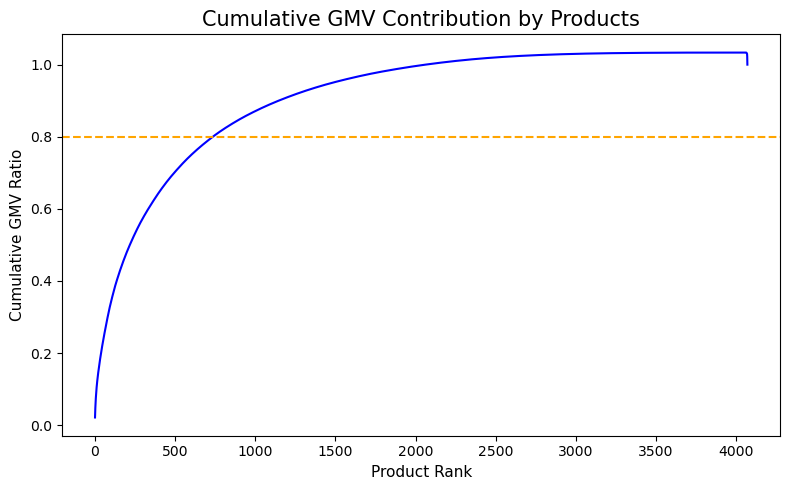

In [30]:
## draw figure
plt.figure(figsize = (8, 5))
plt.plot(range(1, len(cum_gmv_ratio) + 1), cum_gmv_ratio.values, color = 'b')
plt.axhline(0.8, linestyle = '--', color = 'orange')
plt.title('Cumulative GMV Contribution by Products', fontsize = 15)
plt.xlabel('Product Rank', fontsize = 11)
plt.ylabel('Cumulative GMV Ratio', fontsize = 11)
plt.tight_layout()
plt.show()

In [31]:
## how many products contribute to 80% GMV?
(cum_gmv_ratio <= 0.8).sum()

735

**Conclusion:**

As shown in the figure, the long and flat tail in the cumulative GMV curve shows the occurrence of a large number of low-selling products, that is, these products have limited contribution to total sales. This is consistent with the long-tail distribution above. Within about 4000 products, approximately 730 products account for 80% of GMV.

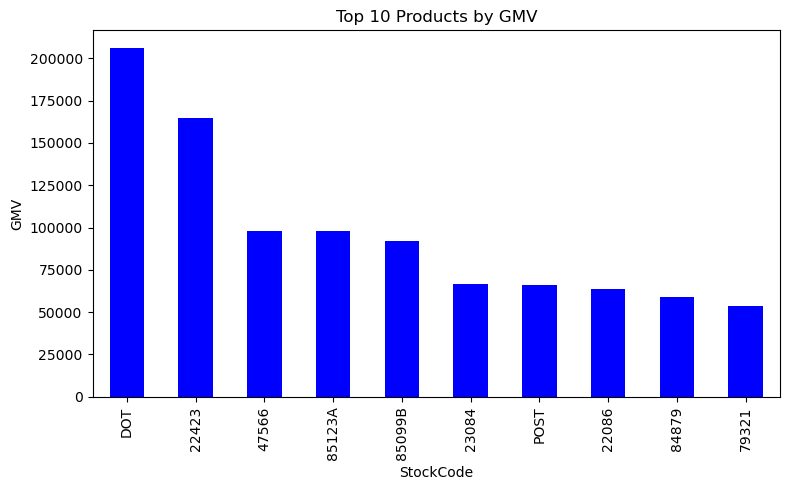

In [32]:
# top 10 by GMV
top10 = sales_sorted.head(10)
top10.plot(
    kind = 'bar',
    figsize = (8, 5),
    title = 'Top 10 Products by GMV',
    color = 'b'
)
plt.ylabel('GMV')
plt.tight_layout()
plt.show()

**Conclusion:**

As shown in the figure, the total sale of the best seller (StockCode: DOT) has been over 200 thousand pounds, which becomes an important revenue driver for the company. However, its sales is basically par with the total sales of other top-selling products, which indicates that the product structure of company has a relatively high degree of concentration, but there is no situation of excessive concentration.

<h3>4. Country-level Analysis</h3>

In [33]:
# order distribution by country
orders_by_country = (
    df
    .groupby('Country')['InvoiceNo']
    .nunique()
)
orders_by_country = orders_by_country.sort_values(ascending = False)

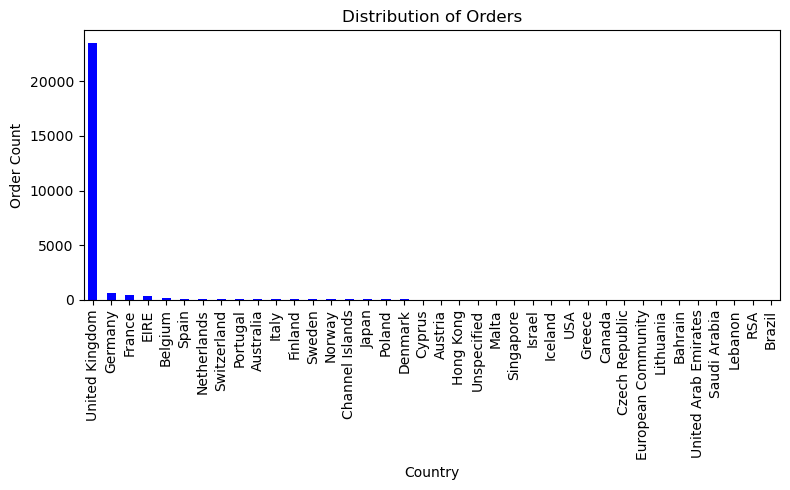

In [34]:
## draw figure
orders_by_country.plot(
    kind = 'bar',
    figsize = (8, 5),
    title = 'Distribution of Orders',
    color = 'b'
)
plt.ylabel('Order Count')
plt.tight_layout()
plt.show()

In [35]:
# GMV distribution by country
gmv_by_country = (
    df
    .groupby('Country')['sales']
    .sum()
)
gmv_by_country = gmv_by_country.sort_values(ascending = False)

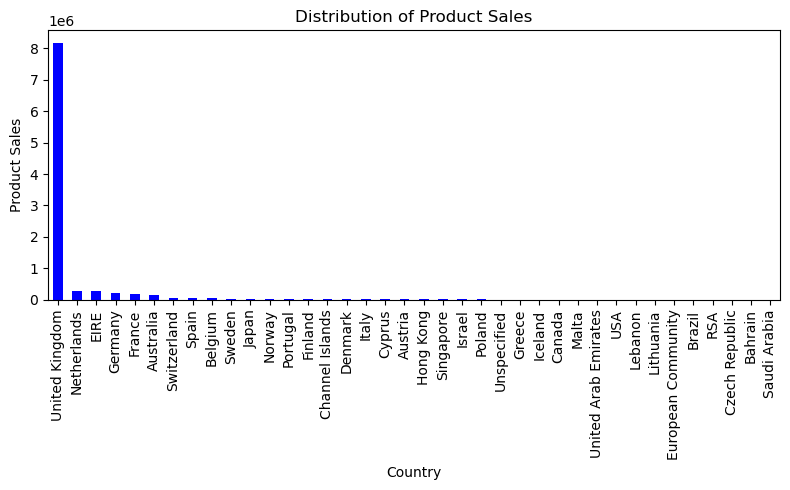

In [36]:
## draw figure
gmv_by_country.plot(
    kind = 'bar',
    figsize = (8, 5),
    title = 'Distribution of Product Sales',
    color = 'b'
)
plt.ylabel('Product Sales')
plt.tight_layout()
plt.show()

**Conclusion:**

As shown in the figure, the vast majority of orders and GMV concentrates on the United Kingdom, which means that UK's transactions occupy the leading position in terms of purchase frequency and benefit contribution in all countries.

In [37]:
# UK vs non-UK
df['region'] = df['Country'].apply(
    lambda x: 'UK' if x == 'United Kingdom' else 'Non-UK'
)

In [38]:
region_summary = (
    df
    .groupby('region')
    .agg(
        order_cnt = ('InvoiceNo', 'nunique'),
        gmv = ('sales', 'sum')
    )
)
region_summary

,order_cnt,gmv
region,,
Non-UK,2406,1558878.77
UK,23494,8167128.18


In [39]:
uk_order_ratio = (
    region_summary.loc['UK', 'order_cnt'] / region_summary['order_cnt'].sum()
)
uk_gmv_ratio = (
    region_summary.loc['UK', 'gmv'] / region_summary['gmv'].sum()
)
print(f'ratio of orders from UK in all orders: {round(uk_order_ratio, 2)}')
print(f'ratio of GMV from UK in total GMV: {round(uk_gmv_ratio, 2)}')

ratio of orders from UK in all orders: 0.91
ratio of GMV from UK in total GMV: 0.84


In [40]:
# average order value by country
country_summary = (
    df
    .groupby('Country')
    .agg(
        order_cnt = ('InvoiceNo', 'nunique'),
        gmv = ('sales', 'sum')
    )
)
country_summary['aov'] = (
    country_summary['gmv'] / country_summary['order_cnt']
)

In [41]:
country_summary[
    country_summary['order_cnt'] < 200
].sort_values('aov', ascending = False).head(5)

,order_cnt,gmv,aov
Country,,,
Netherlands,101,284661.54,2818.431089
Australia,69,137009.77,1985.648841
Lebanon,1,1693.88,1693.880000
Japan,28,35340.62,1262.165000
Brazil,1,1143.60,1143.600000


**Conclusion:**

As shown in the table, although the amount of transactions in non-UK markets accounts for relatively small share, some countries (such as Netherlands and Australia) have much stronger average orders value than UK. This indicates that international demand is limited in scale, however, it often involves larger transaction volumes.

<h3>5. Customer-level Analysis (Identified)</h3>

In [42]:
# each customer: order count, total sales, average sales
orders_sales_by_customer = (
    df[df['customer_flag'] == 'identified']
    .groupby('CustomerID')
    .agg(
        order_cnt = ('InvoiceNo', 'nunique'),
        gmv = ('sales', 'sum')
    )
)
orders_sales_by_customer['sale_avg'] = (
    orders_sales_by_customer['gmv'] / orders_sales_by_customer['order_cnt']
)

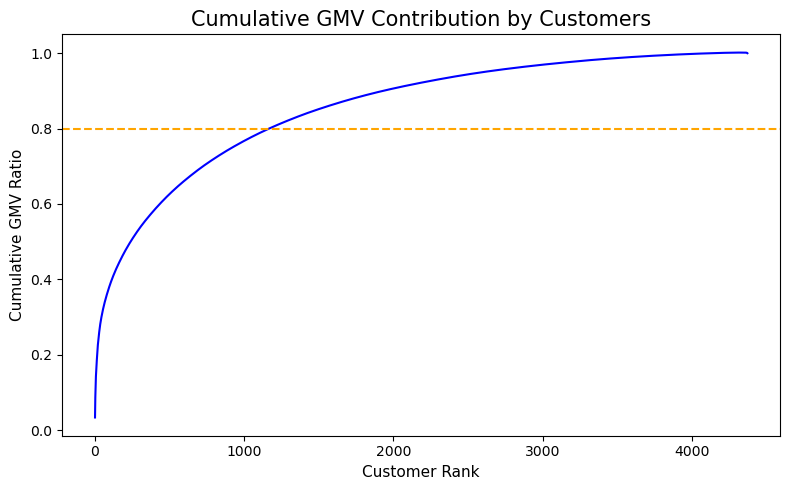

In [43]:
# cumulative customer gmv distribution 
customer_gmv = (
    orders_sales_by_customer['gmv']
    .sort_values(ascending = False)
)
cum_cusgmv_ratio = customer_gmv.cumsum() / customer_gmv.sum()
## draw figure
plt.figure(figsize = (8, 5))
plt.plot(range(1, len(cum_cusgmv_ratio) + 1), cum_cusgmv_ratio.values, color = 'b')
plt.axhline(0.8, linestyle = '--', color = 'orange')
plt.title('Cumulative GMV Contribution by Customers', fontsize = 15)
plt.xlabel('Customer Rank', fontsize = 11)
plt.ylabel('Cumulative GMV Ratio', fontsize = 11)
plt.tight_layout()
plt.show()

In [44]:
## how many customers contribute to 80% GMV?
round((cum_cusgmv_ratio <= 0.8).sum() / len(customer_gmv), 3)

0.267

**Conclusion:**

As shown in the figure, the customer-level analysis reflects a significant lont-tail distribution. Among them, approximately 26.7% of customers contribute 80% of total GMV. This means that the revenue is driven mainly by a proportion of high-value customers. While most customers have slight individual value contribution.

<h3>6. Returns Analysis</h3>

In [45]:
# monthly return order count
orders_by_return = (
    df[df['Quantity'] < 0]
    .groupby('year_month')['InvoiceNo']
    .nunique()
)
orders_by_return = orders_by_return.sort_index()

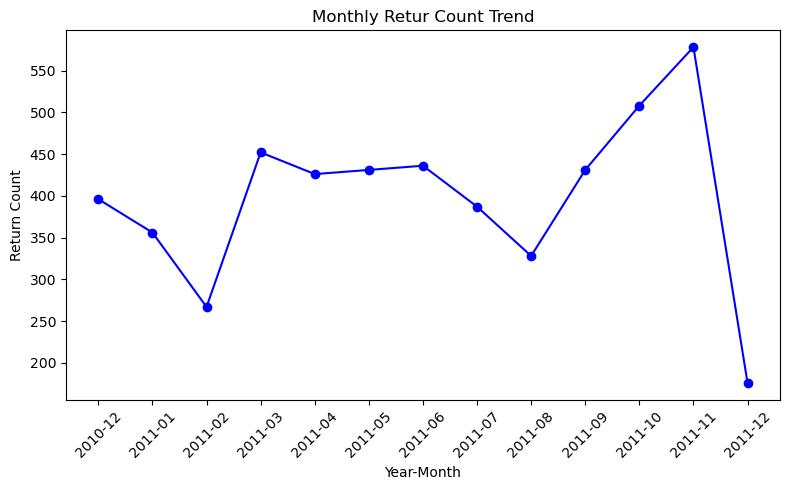

In [46]:
## draw figure
x4 = orders_by_return.index.astype(str)
y4 = orders_by_return.values
plt.figure(figsize = (8, 5))
plt.plot(
    x4, y4, marker = 'o', linestyle = '-', color = 'b'
)
plt.title('Monthly Retur Count Trend')
plt.xlabel('Year-Month')
plt.ylabel('Return Count')
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

**Conclusion:**

As shown in the figure, returns and number of transactions are proportional over time and donot show an abnormal seasonal pattern.

In [47]:
# whether return concentrates on few products?
products_by_return = (
    df[df['Quantity'] < 0]
    .groupby('StockCode')['InvoiceNo']
    .nunique()
)
products_by_return = products_by_return.sort_values(ascending = False)
cum_return_product = products_by_return.cumsum() / products_by_return.sum()

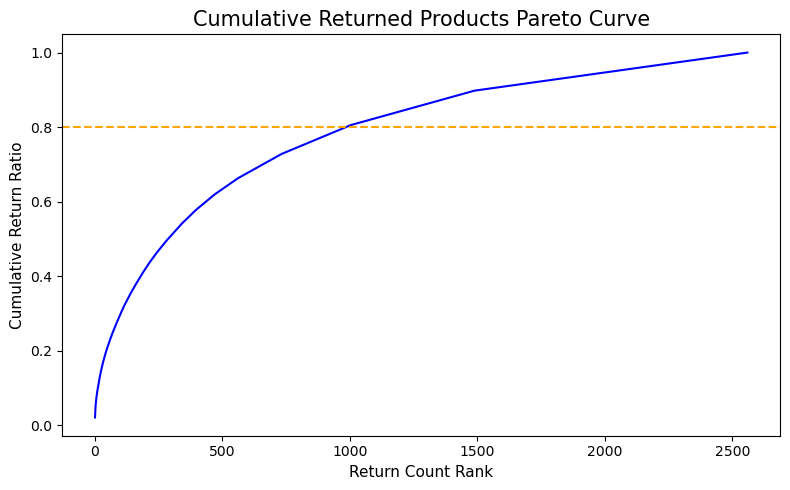

In [48]:
## draw figure
plt.figure(figsize = (8, 5))
plt.plot(range(1, len(cum_return_product) + 1), cum_return_product.values, color = 'b')
plt.axhline(0.8, linestyle = '--', color = 'orange')
plt.title('Cumulative Returned Products Pareto Curve', fontsize = 15)
plt.xlabel('Return Count Rank', fontsize = 11)
plt.ylabel('Cumulative Return Ratio', fontsize = 11)
plt.tight_layout()
plt.show()

In [49]:
# impact on GMV
cancel_ratio

0.0842

**Conclusion:**

As shown in the figure, the first 40% of products have contributed 80% of returned amount. Although the return amount accounts for 8% of total sales of transactions, it concentrates highly on few products. This indicates that the potential opportunity might occur in the improvement of targeted products, rather than systematic pricing or business operation.

<h4><b>Summary:</b></h4>

Current EDA has fully shown the core characteristics at the levels of transactions, time, products, countries, and customers, and provided a clear and reliable analysis boundary for the subsequent customer-level analysis (such as RFM, retention, or segmentation).

<h2>F. Feature Engineering</h2>

<h3>0. Confirm Constraints</h3>

This study focus only on identified customers, because anonymous transactions cannot be reliabliy attributed to the customer level. Due to incomplete observation period, transactions for December 2011 were excluded.

In [50]:
# create new transaction-level dataframe
newdf = df[
    (df['customer_flag'] == 'identified') & 
    (df['year_month'] != '2011-12')
    ]

This is to set up customer-level Dataframesfor merging the metrics of each customer and facilitating subsequent customer segmentation analysis.

In [51]:
# create new customer-level dataframe
customer_features_df = (
    newdf[['CustomerID']]
    .drop_duplicates()
    .reset_index(drop =  True)
)

Cancelled transactions will be retained and regarded as product returns because they contain meaningful behavioral signals. Quantity adjustment labelled as 'other' will be retained at this stage to preserve transaction patterns that may have reference value and will be processed during the feature construction process.

<h3>1. Transaction Status-based Aggregation</h3>

(a) Total number of orders
* *purchase_freq* - normal transactions
* *cancel_freq* - cancelled transactions
* *other_adjustment_freq* - transactions with other adjustment

In RFM analysis, F is *purchase_freq*.

In [52]:
# frequency
purchase_freq = (
    newdf[newdf['quan_cancel_flag'] == 'normal']['InvoiceNo']
    .nunique()
)
cancel_freq = (
    newdf[newdf['quan_cancel_flag'] == 'cancelled']['InvoiceNo']
    .nunique()
)
other_adjustment_freq = (
    newdf[newdf['quan_cancel_flag'] == 'other']['InvoiceNo']
    .nunique()
)
purchase_freq, cancel_freq, other_adjustment_freq

(17758, 3511, 0)

(b) Total number of items:
* *gross_quan* - normal transactions
* *return_quan* - cancelled transactions
* *other_neg_quan* - transactions with other adjustment
* *net_quan* - only for scale description and not directly for RFM or consumption intensity analysis

In [53]:
# quantity
gross_quan = (
    newdf[newdf['quan_cancel_flag'] == 'normal']['Quantity']
    .sum()
)
return_quan = (
    newdf[newdf['quan_cancel_flag'] == 'cancelled']['Quantity']
    .sum()
)
other_neg_quan = (
    newdf[newdf['quan_cancel_flag'] == 'other']['Quantity']
    .sum()
)
net_quan = gross_quan + return_quan + other_neg_quan
gross_quan, return_quan, other_neg_quan, net_quan

(4879109, -189470, 0, 4689639)

(c) Total gross merchandise volume:
* *gross_gmv* - normal transactions
* *refund_gmv* - cancelled transactions
* *other_adjustment_gmv* - transactions with other adjustment
* *net_gmv* - for the overall value assessment of customers

In [54]:
# GMV
gross_gmv = (
    newdf[newdf['quan_cancel_flag'] == 'normal']['sales']
    .sum()
)
refund_gmv = (
    newdf[newdf['quan_cancel_flag'] == 'cancelled']['sales']
    .sum()
)
other_adjustment_gmv = (
    newdf[newdf['quan_cancel_flag'] == 'other']['sales']
    .sum()
)
net_gmv = gross_gmv + refund_gmv + other_adjustment_gmv
gross_gmv, refund_gmv, other_adjustment_gmv, net_gmv

(8370018.449999997, -433038.46, 0.0, 7936979.989999997)

(d) Average order value 

An indicator of consumption intensity

In [55]:
# AOV
aov = gross_gmv / purchase_freq
round(aov, 2)

471.34

(e) Average quantity of products per order

In [56]:
# average items per order
avg_items_per_purchase_normal = gross_quan / purchase_freq
round(avg_items_per_purchase_normal, 2)

274.76

It is expected that there will be a significant difference in the average quantity of items between the transaction level and the customer level (20.72 vs 274.76). From the perspective of customers, this dataset reflects the bulk purchasing behavior of customers with high transaction volumes. Therefore, it is expected that the average quantity of products per order will be much higher than that of a typical B2C transaction.

Return-related features are not included in the average order value (AOV) or purchase frequency metrics as they do not represent new purchase decisions. However, these features will be retained to enable a more in-depth analysis of customer behavior.

<h3>2. Customer-level RFM</h3>

The recency is defined as the number of days between the cut-off date (November 30, 2011) and the customer's most recent normal purchase transaction. Cancelled and adjusted transactions are not included as they do not represent new purchase decisions.

In [57]:
# key metric: first & last purchase date, valid orders
key_metric = (
    newdf[newdf['quan_cancel_flag'] == 'normal']
    .groupby('CustomerID')
    .agg(
        first_purchase_date = ('invoice_date', 'min'),
        last_purchase_date = ('invoice_date', 'max'),
        purchase_freq = ('InvoiceNo', 'nunique'), ## frequency - purchase frequency
        gross_gmv = ('sales', 'sum'), ## monetary - gross gmv
        total_quan = ('Quantity', 'sum'),
        max_single_order_value = ('sales', 'max')
    )
)
## uniform time granularity
key_metric['first_purchase_date'] = key_metric['first_purchase_date'].dt.normalize()
key_metric['last_purchase_date'] = key_metric['last_purchase_date'].dt.normalize()

In [58]:
# recency
cut_off = pd.Timestamp('2011-11-30')
key_metric['recency'] = (cut_off - key_metric['last_purchase_date']).dt.days

In [59]:
# frequency
## active period days
key_metric['active_period_days'] = (
    key_metric['last_purchase_date'] - key_metric['first_purchase_date']
).dt.days

In [60]:
## average orders per month (30.42 day/month = 365/12)
key_metric['avg_orders_per_month'] = round(
    key_metric['purchase_freq'] / (key_metric['active_period_days'] / 30.42)
    , 4
)

In [61]:
# monetary
## AOV
key_metric['avg_order_value'] = round(
    key_metric['gross_gmv'] / key_metric['purchase_freq']
    , 4
)

In [62]:
## average price
key_metric['avg_items_price'] = round(
    key_metric['gross_gmv'] / key_metric['total_quan']
    , 4
)

In [63]:
## merge into customer-level dataframe
customer_features_df = customer_features_df.merge(
    key_metric,
    on = 'CustomerID',
    how = 'left'
)

Based on valid purchase transactions, we use RFM (Most Recent Purchase Time, Purchase Frequency, Purchase Amount) metrics to measure customer value, ensuring that purchase frequency and amount reflect genuine consumption behavior rather than operational adjustments.

<h3>3. Customer-level Friction & Risk</h3>

Only transactions that are explicitly cancelled are regarded as returns. Transactions marked as "other" are not considered due to their ambiguous business semantics. 

RFM measures customer value from the perspective of income, it doesn't take into account the return operation caused by friction. Some customers may bring high returns, but at the same time, they will also incur high costs related to returns.

In [64]:
# return metric: return frequency & return GMV
return_metric = (
    newdf[newdf['quan_cancel_flag'] == 'cancelled']
    .groupby('CustomerID')
    .agg(
        return_freq = ('InvoiceNo', 'nunique'),
        return_gmv = ('sales', 'sum')
    )
)

In [65]:
## merge into customer-level dataframe
customer_features_df = customer_features_df.merge(
    return_metric,
    on = 'CustomerID',
    how = 'left'
)

In [66]:
# has_return
customer_features_df['has_return'] = (
    customer_features_df['return_freq']
    .notna()
    .astype(int)
)
# fill 0 for NaN in return_metric (no return)
customer_features_df[['return_freq', 'return_gmv']] = (
    customer_features_df[['return_freq', 'return_gmv']].fillna(0)
)

In [67]:
# return invoice ratio & return GMV ratio (%)
customer_features_df['return_freq_ratio'] = round(
    customer_features_df['return_freq'] / customer_features_df['purchase_freq']
    , 4
)
customer_features_df['return_gmv_ratio'] = round(
    abs(customer_features_df['return_gmv']) / customer_features_df['gross_gmv']
    , 4
)

In [68]:
# whether return frequently
customer_features_df['has_return_frequent'] = (
    (customer_features_df['purchase_freq'] >= 5) &
    (customer_features_df['return_freq_ratio'] >= 0.20)
).astype(int)

These features related to friction were not analyzed independently. However, it is aimed at supporting downstream customer segmentation and identifying high-value but high-friction customer groups.

<h3>4. Price & Product Preference & Country</h3>

In [69]:
# average unit price
## avg_item_price
# how many products each customer purchases
product_pre = (
    newdf
    .groupby('CustomerID')['StockCode']
    .nunique()
)

These features can reflect customers' price sensitivity and product diversity, and help distinguish between repeat purchase behavior and exploratory purchase behavior.

In [70]:
## merge into customer-level dataframe
customer_features_df = customer_features_df.merge(
    product_pre,
    on = 'CustomerID',
    how = 'left'
)

In [71]:
# if country is UK
uk_flag = (
    newdf
    .groupby('CustomerID')['region']
    .first()
    .eq('UK')
    .astype(int)
    .rename('is_uk_customer')
)
## merge into customer-level dataframe
customer_features_df = customer_features_df.merge(
    uk_flag,
    on = 'CustomerID',
    how = 'left'
)

Given that transactions are mainly concentrated in the UK, country information is only used as a rough indicator (UK and non-UK), rather than as the main behavioral feature.

In [72]:
customer_features_df.head(10)

,CustomerID,first_purchase_date,last_purchase_date,purchase_freq,gross_gmv,total_quan,max_single_order_value,recency,active_period_days,avg_orders_per_month,avg_order_value,avg_items_price,return_freq,return_gmv,has_return,return_freq_ratio,return_gmv_ratio,has_return_frequent,StockCode,is_uk_customer
0,17850,2010-12-01,2010-12-02,34.0,5391.21,1733.0,107.25,363.0,1.0,1034.2800,158.5650,3.1109,1.0,-87.73,1,0.0294,0.0163,0,24,1
1,13047,2010-12-01,2011-11-08,10.0,3237.54,1391.0,68.00,22.0,342.0,0.8895,323.7540,2.3275,8.0,-158.44,1,0.8000,0.0489,1,106,1
2,12583,2010-12-01,2011-11-21,14.0,6586.61,4748.0,132.80,9.0,355.0,1.1997,470.4721,1.3872,3.0,-94.04,1,0.2143,0.0143,1,110,0
3,13748,2010-12-01,2011-09-05,5.0,948.25,439.0,204.00,86.0,278.0,0.5471,189.6500,2.1600,0.0,0.00,0,0.0000,0.0000,0,24,1
4,15100,2010-12-01,2011-01-10,3.0,876.00,80.0,350.40,324.0,40.0,2.2815,292.0000,10.9500,3.0,-240.90,1,1.0000,0.2750,0,1,1
5,15291,2010-12-01,2011-11-14,15.0,4668.30,2103.0,243.36,16.0,348.0,1.3112,311.2200,2.2198,5.0,-71.79,1,0.3333,0.0154,1,63,1
6,14688,2010-12-01,2011-10-31,19.0,4949.83,3292.0,153.00,30.0,334.0,1.7305,260.5174,1.5036,5.0,-500.35,1,0.2632,0.1011,1,117,1
7,17809,2010-12-01,2011-11-23,12.0,5411.91,2057.0,425.00,7.0,357.0,1.0225,450.9925,2.6310,3.0,-784.29,1,0.2500,0.1449,1,47,1
8,15311,2010-12-01,2011-11-29,88.0,59457.10,37639.0,408.00,1.0,363.0,7.3745,675.6489,1.5797,25.0,-1239.06,1,0.2841,0.0208,1,565,1
9,16098,2010-12-01,2011-09-13,7.0,2005.63,613.0,178.20,78.0,286.0,0.7445,286.5186,3.2718,0.0,0.00,0,0.0000,0.0000,0,34,1


At this stage, we did not perform feature transformation or outlier handling because the goal of feature engineering is feature representation rather than modeling. All the constructed features are integrated into a customer-level dataset for subsequent segmentation analysis.

<h2>G. Customer Segmentation</h2>

<h3>1. Feature Selection</h3>

Starting from the four dimensions of customer purchasing behavior: 

* gross_gmv
* purchase_freq
* avg_orders_per_month
* recency
* active_period_days
* return_freq_ratio
* avg_items_price

Selecting numerical characteristics at the customer level, all features can depict the overall transaction patterns and behavioral differences of customers from different perspectives and to a certain extent avoid information redundancy. 

Among them, value-related features are used to measure the revenue contribution of customers, frequency and time-related features are used to describe the activity level and life cycle characteristics of customers, while return-related indicators reflect the stability of customer behavior and potential operating costs. 

All features are applicable to distance-based clustering methods, which are helpful for generating customer segmentation results with business interpretability in the subsequent process.



<h3>2. Feature Pre-processing</h3>

<h4>(a) Missing & Extreme Value Check</h4>

In [73]:
# check NA in selected features
customer_features_df[
    ['gross_gmv', 'purchase_freq', 'avg_orders_per_month',
     'recency', 'active_period_days', 'return_freq_ratio', 'avg_items_price']
].isna().sum()

gross_gmv               33
purchase_freq           33
avg_orders_per_month    33
recency                 33
active_period_days      33
return_freq_ratio       33
avg_items_price         33
dtype: int64

In [74]:
# capture customers with NA
na_customers = customer_features_df[
    customer_features_df[['gross_gmv', 'purchase_freq']].isna().any(axis = 1)
]
na_customers.shape

(33, 20)

In [75]:
# check customers' valid purchase count and total quantity
na_customers[['CustomerID', 'purchase_freq', 'total_quan']].head(10)

,CustomerID,purchase_freq,total_quan
4298,17547,NaN,NaN
4299,13958,NaN,NaN
4300,16995,NaN,NaN
4301,14213,NaN,NaN
4302,14679,NaN,NaN
4303,16138,NaN,NaN
4304,12870,NaN,NaN
4305,16252,NaN,NaN
4306,16579,NaN,NaN
4307,17307,NaN,NaN


In [76]:
# fill NaN with 0
customer_features_df[
    ['gross_gmv', 'purchase_freq', 'avg_orders_per_month',
     'recency', 'active_period_days', 'return_freq_ratio', 'avg_items_price']
] = customer_features_df[
    ['gross_gmv', 'purchase_freq', 'avg_orders_per_month',
     'recency', 'active_period_days', 'return_freq_ratio', 'avg_items_price']
].fillna(0)

**Reason for NaN**: When calculating relevant features such as *purchase_freq*, customers with *quan_cancel_flag* = normal are selected. While *customer_features_df* contains all customers (*quan_cancel_flag* = normal / cancelled / other), and thus left join results in NaN value.

**Solution**: Filling in with 0. Such customers do not have normal purchasing behavior but have returns or other adjustment operations. They should be retained to ensure the completeness of segmentation. 

In [77]:
# check INF in selected features
np.isinf(customer_features_df[
    ['gross_gmv', 'purchase_freq', 'avg_orders_per_month',
     'recency', 'active_period_days', 'return_freq_ratio', 'avg_items_price']
]).sum()

gross_gmv                  0
purchase_freq              0
avg_orders_per_month    1600
recency                    0
active_period_days         0
return_freq_ratio          0
avg_items_price            0
dtype: int64

In [78]:
# replace INF with purchase frequency
inf_mask = np.isinf(customer_features_df['avg_orders_per_month'])

customer_features_df.loc[inf_mask, 'avg_orders_per_month'] = (
    customer_features_df.loc[inf_mask, 'purchase_freq']
)

**Reason for INF**: *avg_orders_per_month* = valid order numbers / active months. All orders might occurs in one month even a single day, and thus the denominator is 0.

**Solution**: Time frame is extremely short, thereby replacing it with purchase frequency.

<h4>(b) Distribution Check</h4>

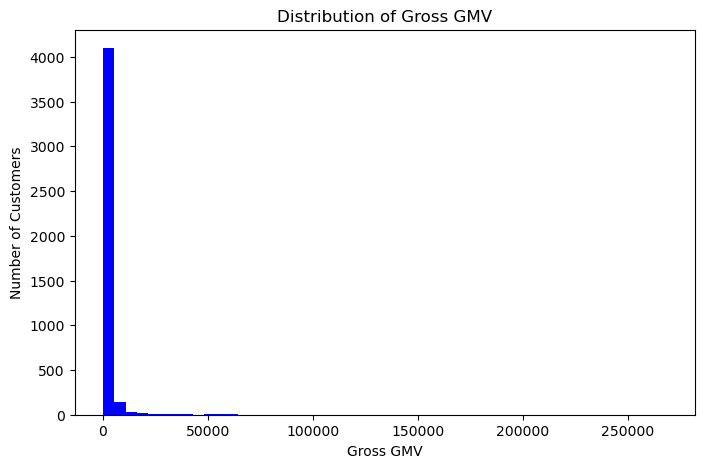

In [79]:
# check gross GMV
customer_features_df['gross_gmv'].plot(
    kind = 'hist',
    bins = 50,
    figsize = (8, 5),
    title = 'Distribution of Gross GMV',
    color = 'b'
)
plt.xlabel('Gross GMV')
plt.ylabel('Number of Customers')
plt.show()

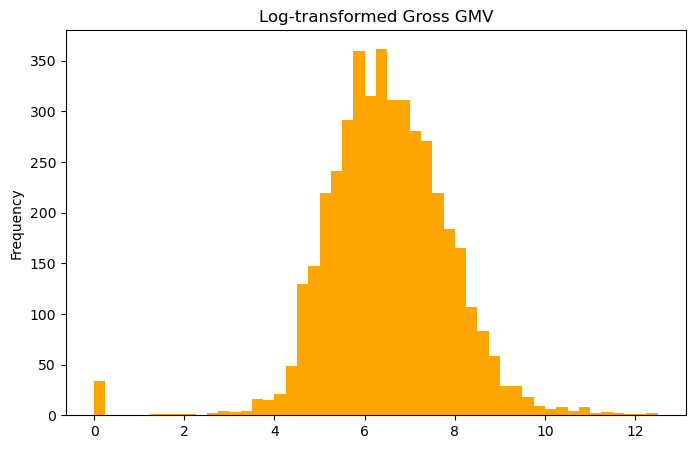

In [80]:
## use log(gross GMV)
customer_features_df['gross_gmv_log'] = np.log1p(customer_features_df['gross_gmv'])

customer_features_df['gross_gmv_log'].plot(
    kind = 'hist',
    bins = 50,
    figsize = (8, 5),
    title = 'Log-transformed Gross GMV',
    color = 'orange'
)
plt.show()

The overall GMV shows a distinct right-skewed distribution, indicating the existence of a small number of high-value customers. Before clustering, logarithmic transformation is applied to reduce skewness.

<h4>(c) Standardization</h4>

In [81]:
# prepare features for clustering
segmentation_features = [
    'gross_gmv_log', 'purchase_freq', 
    'avg_orders_per_month', 'recency', 
    'active_period_days', 'return_freq_ratio', 'avg_items_price'
]

X = customer_features_df[segmentation_features]

In [82]:
from sklearn.preprocessing import StandardScaler
# create a StandardScaler object
scaler = StandardScaler()
# transform
X_scaled = scaler.fit_transform(X)

In [83]:
# convert into DataFrame
X_scaled_df = pd.DataFrame(
    X_scaled,
    columns = segmentation_features,
    index = customer_features_df.index
)
X_scaled_df.describe()

,gross_gmv_log,purchase_freq,avg_orders_per_month,recency,active_period_days,return_freq_ratio,avg_items_price
count,4.331000e+03,4.331000e+03,4.331000e+03,4.331000e+03,4.331000e+03,4.331000e+03,4.331000e+03
mean,-3.674938e-16,-5.249912e-17,9.023286e-18,-7.874868e-17,-5.249912e-17,5.249912e-17,-1.312478e-17
std,1.000115e+00,1.000115e+00,1.000115e+00,1.000115e+00,1.000115e+00,1.000115e+00,1.000115e+00
min,-4.740183e+00,-5.540974e-01,-9.630660e-02,-9.113769e-01,-9.644593e-01,-5.295642e-01,-9.046627e-02
25%,-5.861689e-01,-4.189585e-01,-5.804024e-02,-7.590955e-01,-9.644593e-01,-5.295642e-01,-4.832111e-02
50%,-3.028365e-02,-2.838197e-01,-3.466620e-02,-4.240765e-01,-3.289885e-01,-5.295642e-01,-3.628523e-02
75%,6.256538e-01,-1.354197e-02,-3.466620e-02,5.302199e-01,9.342033e-01,2.283714e-01,-1.965729e-02
max,4.360229e+00,2.660881e+01,6.365714e+01,2.783984e+00,1.856411e+00,1.159741e+01,6.106965e+01


<h3>3. KMeans Clustering</h3>

KMeans clustering was selected as the primary segmentation method because the task focuses on unsupervised customer segmentation based on continuous numerical behavioral features.

KMeans provides a clear and interpretable clustering structure by assigning each customer to exactly one cluster and representing each segment through a centroid, which aligns well with the objective of building actionable customer profiles.

Compared with alternative clustering methods, KMeans offers a good balance between simplicity, scalability, and interpretability, making it suitable for exploratory business analysis and downstream decision-making.

<h4>(a) Choose Clustering Number</h4>

K value selection uses interpretability and business availability of customer segmentation as the main considerations. The objective of this study is not to discover a plenty of fragmented customer groups, but to identify several representative customer behavior patterns to support subsequent customer profiling analysis and business decisions. Therefore, the candidate range of K value is limited to between 3 and 6 to strike a balance between model complexity and interpretability of the results.

Step 1: Elbow Method

Elbow Method is to observe the benefits when K takes different values.

In [84]:
from sklearn.cluster import KMeans
wcss = []
k_range = range(2, 9)
for i in k_range:
    kmeans = KMeans(n_clusters = i, random_state = 42, n_init = 10)
    kmeans.fit(X_scaled_df)
    wcss.append(kmeans.inertia_)

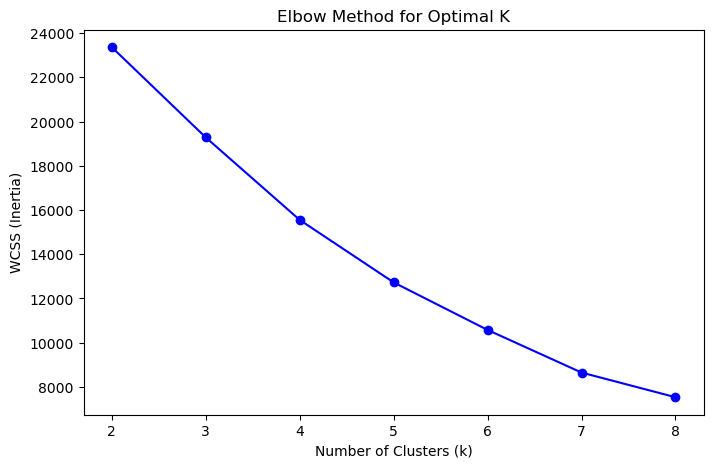

In [85]:
# plot elbow-method curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, wcss, marker = 'o', color = 'b')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.show()

As shown in the figure, the decreasing trend is relatively significant from K = 2 to K = 5 and slows down between K = 6 and K = 8 with gradually smaller benefits. This means that K = 4 or K = 5 will be relatively reasonable.

Step 2: Silhouette Score

Silhouette Score is to determine whether data point is assigned to the correct cluster. Higher score indicates better similarity of data point within one cluster. 

In [86]:
from sklearn.metrics import silhouette_score
silhouette_scores = []
for k in k_range:
    kmeans = KMeans(n_clusters = k, random_state = 42, n_init = 10)
    labels = kmeans.fit_predict(X_scaled_df)
    ## calculate score
    score = silhouette_score(X_scaled_df, labels)
    silhouette_scores.append(score)
    print(f'When K = {k}, silhouette score is {score:.4f}')

When K = 2, silhouette score is 0.3342
When K = 3, silhouette score is 0.3366
When K = 4, silhouette score is 0.3389
When K = 5, silhouette score is 0.3714
When K = 6, silhouette score is 0.3454
When K = 7, silhouette score is 0.3593
When K = 8, silhouette score is 0.3453


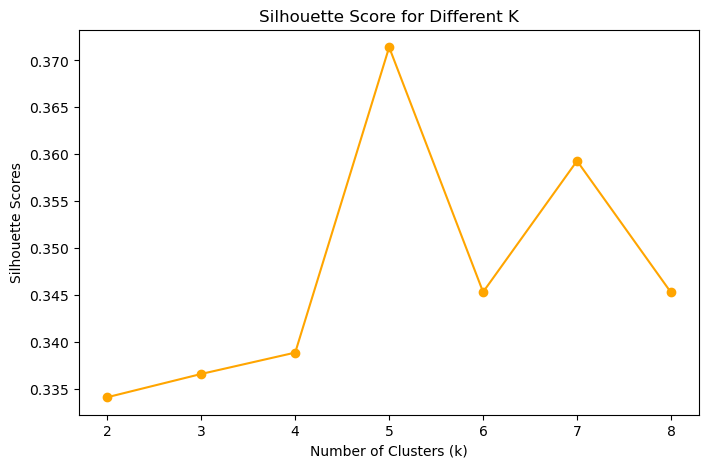

In [87]:
## visualize silhouette-score change
plt.figure(figsize=(8, 5))
plt.plot(k_range, silhouette_scores, marker = 'o', color = 'orange')
plt.title('Silhouette Score for Different K')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Scores')
plt.show()

As shown in the figure, the Silhouette Score increases slowly between K = 2 and K = 4, obviously leap when K = 5, and starts dropping after K = 6.

<h4>(b) Determine Final Model</h4>

Based on the Elbow Method and Silhouette Analysis, K = 5 provides the best balance between the cluster compactness and separation.

In [88]:
kmeans = KMeans(n_clusters = 5, random_state = 42, n_init = 10)
clusters = kmeans.fit_predict(X_scaled_df)

<h4>(c) Inverse Standardization</h4>

Based on the results obtained from KMeans clustering model, each customer can be assigned to one of five cluster, representing by cluster numbers.

In [89]:
# wirte back to original customer-level dataframe
customer_features_df['cluster'] = clusters

Through inverse standardization in scaled data, the centroid of various features of all customers in each cluster can be represented.

In [90]:
# inverse standardization: cluster centers
centers_scaled = kmeans.cluster_centers_
centers_original = pd.DataFrame(
    scaler.inverse_transform(centers_scaled),
    columns = X_scaled_df.columns
)
centers_original['cluster'] = range(5)
centers_original

,gross_gmv_log,purchase_freq,avg_orders_per_month,recency,active_period_days,return_freq_ratio,avg_items_price,cluster
0,6.351652,1.940452,1.439185,132.359343,60.449692,0.913413,4.787624,0
1,7.567389,7.775487,1.048379,30.081329,258.383162,0.167339,1.923210,1
2,7.617809,1.000000,1.000000,76.000000,0.000000,0.000000,2033.100000,2
3,5.666970,1.527672,1.526763,129.477099,27.874523,0.009292,2.528111,3
4,8.592711,34.000000,1034.280000,363.000000,1.000000,0.029400,3.110900,4


<h4>(d) Customer Profiling Hypothesis</h4>

Based on feature mean values of five clusters, there can initially derive customers' typical representative profiles.

**Cluster 0 & 3 - One-off / Inactive Customers**  
* **Characteristic**: The overall GMV of this type of customers is relatively low, and their purchase frequency is also low. Orders are mainly concentrated within a short period of time (about 1-2 months). Moreover, the recency is relatively high, and no sustained active behavior has been demonstrated recently.   
* **Preliminary judgment**：This type of customers might be one-time or occasional purhcases. The overall customer value is relatively low and there are no obvious characteristics of repurchase or retention at the current stage.

**Cluster 1 - Core Loyal Customers**  
* **Characteristic**：This type of customers is relatively high, a long active period, a low refund rate, and a low recency. They performs stable and continuous recent active behavior.  
* **Preliminary judgment**：This type of customers has stable purchase patterns and high customer value, and can be regarded as the core customer group of the current business, with strong loyalty.

**Cluster 2 - One-time High-Value Customers**  
* **Characteristic**：This type of customers has a relatively high GMV, but only makes a single purchase, and has no active days. The average unit price of products is significantly higher than that of other groups.  
* **Preliminary judgment**：This might correspond to one-time large-scale consumption behaviors, such as bulk purchasing, B2B scenarios, or concentrated purchases in specific situations (such as gift purchasing). Whether this group has long-term value still needs to be further verified in combination with subsequent behaviors.

**Cluster 4 - Burst Purchase Customers**  
* **Characteristic**：This type of customers has the highest GMV, and the number of orders placed and average number of orders placed are significantly higher than other clusters. But the active period is extremely short (in one day). The recency is higher which means that no purchase behavior occurs recently.   
* **Preliminary judgment**：This type of customers might correspond to a short-term concentrated or burst purchase pattern, such as wholesale purchases, orders triggered by special events. There does not exclude the possibility of anormal data or atypical customer behavior.

<h4>(e) Profiling Validation</h4>

Using original and real customer data to verify customer profiling hypothesis based on *centers_original*.

In [91]:
# sanity check
## whether each customer stays in a single cluster
cnt = customer_features_df.groupby('CustomerID')['cluster'].nunique()
cnt.value_counts(ascending = True)

cluster
1    4331
Name: count, dtype: int64

In [92]:
## cluster range
min_cluster = customer_features_df['cluster'].min()
max_cluster = customer_features_df['cluster'].max()
min_cluster, max_cluster

(0, 4)

**Conclusion:**
* Each customer stays in only one cluster.
* Cluster range: {0, 1, 2, 3, 4}

In [93]:
# customer size structure
## which cluster of customer is most: count & percentage
cluster_cnt = (
    customer_features_df
    .groupby('cluster')['CustomerID']
    .nunique()
)
cluster_pct = cluster_cnt / cluster_cnt.sum()

In [94]:
## convert into dataframe
cluster_cus = pd.DataFrame({
    'Count': cluster_cnt,
    'Percent %': cluster_pct
})
cluster_cus

,Count,Percent %
cluster,,
0,487,0.112445
1,1747,0.403371
2,1,0.000231
3,2095,0.483722
4,1,0.000231


**Conclusion:**
* Customer size mainly concentrates on Cluster 1 and Cluster 3, and the two together account for the vast majority of customers.
* Cluster 2 and Cluster 4 have extremely small customer size, showing highly concentreated or extremely behavior characteristics.
* The overall distribution is consistent with initial profiling hypothesis.

In [95]:
# value structure
## who contributes most GMV: total & per capita
cluster_gmv = (
    customer_features_df
    .groupby('cluster')['gross_gmv']
    .sum()
)
cluster_gmv_pc = cluster_gmv / cluster_cnt

In [96]:
## convert into dataframe
cluster_val = pd.DataFrame({
    'GMV (Total)': cluster_gmv,
    'GMV (Per Capita)': round(cluster_gmv_pc, 2)
})
cluster_val

,GMV (Total),GMV (Per Capita)
cluster,,
0,539005.63,1106.79
1,6911512.37,3956.22
2,2033.10,2033.10
3,912076.14,435.36
4,5391.21,5391.21


**Conclusion:**
* Cluster 1 is the customer group with the highest overall GMV contribution, and it also has a relatively high per capita GMV, demonstrating stable and scalable customer value.
* Although the contribution value of Cluster is also relativel, the per capita value is very low due to the large scale of customers.
* The overall GMV of Cluster 0 is limited, but it has a considerable performance in the per capita value.
* Due to extremely small population of Cluster 2 and Cluster 4, its value metrics do not have statistic representativeness.

In [97]:
# behavior stability
cluster_beh = (
    customer_features_df
    .groupby('cluster')
    .agg(
        avg_pur = ('purchase_freq', 'mean'),
        avg_mon = ('avg_orders_per_month', 'mean'),
        avg_act = ('active_period_days', 'mean')
    )
)
cluster_beh

,avg_pur,avg_mon,avg_act
cluster,,,
0,1.940452,1.439185,60.449692
1,7.772753,1.048277,258.295363
2,1.000000,1.000000,0.000000
3,1.526969,1.527077,27.837709
4,34.000000,1034.280000,1.000000


In [98]:
# retention & churn signal
cluster_retain_churn = (
    customer_features_df
    .groupby('cluster')
    .agg(
        avg_rec = ('recency', 'mean'),
        sum_gmv = ('gross_gmv', 'sum')
    )
)
cluster_retain_churn

,avg_rec,sum_gmv
cluster,,
0,132.359343,539005.63
1,30.113910,6911512.37
2,76.000000,2033.10
3,129.497375,912076.14
4,363.000000,5391.21


**Conclusion:**
* Cluster 1 performs relatively strong stability in the purchase frequency, active period, and recency and thus can be regarded as the core customer group.
* Cluster 0 and Cluster 3 both show higher recency and relatively low activity level recently.

In [99]:
# friction & risk
cluster_risk = (
    customer_features_df
    .groupby('cluster')
    .agg(
        avg_return_freq = ('return_freq_ratio', 'mean'),
        avg_return_gmv = ('return_gmv_ratio', 'mean'),
        sum_gmv = ('gross_gmv', 'sum')
    )
)
cluster_risk

,avg_return_freq,avg_return_gmv,sum_gmv
cluster,,,
0,0.913413,0.259555,539005.63
1,0.167434,0.021383,6911512.37
2,0.000000,0.000000,2033.10
3,0.009137,0.002928,912076.14
4,0.029400,0.016300,5391.21


**Conclusion:**
* Cluster 0 has a moderate overall value. However, the frequency of refunds and the proportion of return amounts are relatively high, presenting a relatively significant risk of friction.
* Cluster 3 shows relatively less refund behavior and has certain potential recovery value.
* Cluster 1 performs the best overall in terms of friction and risk metrics.

**For Cluster 2 and Cluster 4,**  
Each of them only contains a single customer, their behavior pattern donot have representativeness for overall customer structure and business decisions. At the current stage, it is more suitable to record them as abnormal or special cases rather than as key operational targets.

<h2>H. Business Implication</h2>

These clusters represent distinct purchasing behaviors in terms of frequency, monetary value, and engagement duration, which allows us to reason about how customers may respond differently to business interventions.

<h3>1. Which clusters should be prioritized?</h3>

* **Cluster 1** represents the core customer group, which is characterized by a large customer base, high contribution to total GMV, and relatively stable behaviour patterns. This group can be given priority for maintaining a continuous relationship.
* **Cluster 3** also accounts for a relatively high proportion and contributes a considerable total GMV. But their activity level has been relatively low recently. Low-cost customer remarketing campaigns targeting this group can be considered.
* **Cluster 0** has a small customer size with moderate per capita GMV, but performs a relatively high refund rate. Rather than prioritizing growth-oriented intervention measures, it is better to conduct closer monitoring of this group from the perspective of cost and risk management.
* **Cluster 2 & 4** each contain only one customer, reflecting highly concentrated or atypical customer behaviour. These clusters are not representative and thus are not given priority in the current analysis.

<h3>2. What strategic directions could be considered?</h3>

Cluster results provides a basis for differentiated customer management rather than for standardized operational decisions.
* For **Cluster 1**: Given its proven stability and value contribution, it is advisable to maintaining engagement through personalized communication and loyal-oriented initiatives. For instance, regular email push notifications, advertisement delivery, and promotional activities for popular or targeted products.
* For **Cluster 3**: Limited reactivation measures (such as eamil alerts or general promotions) can be explored to assess whether the recent inactivity reflects a temporary disengagement.
* For **Cluster 0**: The clustering results show that the friction related to returns is relatively high. Therefore, conducting in-depth research on the product or order features related to returns may be more appropriate than directly simulating purchases.
* For **Cluster 2 & 4**: Due to a lack of representativeness, it has not yet been incorporated into the standard customer strategy.

<h3>3. What are the boundaries of this clustering model?</h3>

Although cluster analysis provides a structured view of customer heterogeneity, some limitations still need to be mentioned.
* This model classifies customers based on historical behavior characteristics, but does not predict an individual's future behavior.
* Cluster method cannot build causality between customer features and objective results, such as root causes resulted in customer historical behavior or practical impacts from previous some initiatives.
* Therefore, strategy directions should be regarded as exploratory and may require further verification using updated dataset.